In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/MyDrive/:D

/gdrive/MyDrive/:D


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import keras
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.17.0


In [ ]:
neuronas=1000
dropout=0.2

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
input=np.load("input_diffused.npy")
input = input[:,:,:,1]

In [ ]:
#Transforming every pixel >0.1 to 1

input[input > 0.1] = 1

In [ ]:
#IMPORT OF EXCEL FILE WITH MEASUREMENTS FOR EACH IMAGE

# Specify the file path if it's not in the root directory
file_path = 'final_dataset.xlsx'

# Read the Excel file into a Pandas DataFrame
df = pd.read_excel(file_path)

# Display the DataFrame
df.head()  # You can use df.head() to display the first few rows of the DataFrame

,filename,Magnification,Mean Nanoparticles,Std Nanoparticles,Min Nanoparticles,Max Nanoparticles,Mean length bars,Std length bars,Min length bars,Max length bars,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,rgb_M8_1.tif,38,16.463461,2.535583,10.958054,19.070644,29.006870,1.155173,28.189988,29.823753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,rgb_M8_1.tif,38,16.463461,2.535583,10.958054,19.070644,29.006870,1.155173,28.189988,29.823753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,rgb_M8_1.tif,38,16.463461,2.535583,10.958054,19.070644,29.006870,1.155173,28.189988,29.823753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,rgb_M8_1.tif,38,16.463461,2.535583,10.958054,19.070644,29.006870,1.155173,28.189988,29.823753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,rgb_M8_1.tif,38,15.222773,2.405427,10.725570,19.389512,25.372931,5.113778,17.061194,34.568803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Trasform dataframe into numpy array
output_one = df.iloc[:,6:14].to_numpy()
#output_one = df.iloc[i:j,6:14].to_numpy()
output_two = np.reshape(df.iloc[:,15].to_numpy(),(352,1))
output = np.concatenate((output_one,output_two),axis=1)

In [ ]:
#INPUT MAGNIFICATION NORMALIZED

input_scalar = np.reshape(df.iloc[:,1].to_numpy(),(352,1))
#input_scalar = np.reshape(df.iloc[i:j,1].to_numpy(),(num,1))
input_scalar = sklearn.preprocessing.normalize(input_scalar, norm='max', axis=0)

In [ ]:
#Resizing input size for Xception model
import tensorflow as tf
from tensorflow.keras.layers import Resizing

input_xception = np.zeros((352,299,299,3))

for i in range(352):
    input_tensor = np.reshape(input[i],(256,304,1))
    input_tensor = Resizing(299, 299, interpolation='bicubic')(input_tensor)
    input_xception[i,:,:,0] = np.reshape(input_tensor, (299,299))
    input_xception[i,:,:,1] = np.reshape(input_tensor, (299,299))
    input_xception[i,:,:,2] = np.reshape(input_tensor, (299,299))

input=input_xception

In [ ]:
#20 80 split
input, input_evaluation, input_scalar, input_scalar_evaluation, output, output_evaluation = train_test_split(input, input_scalar, output, test_size=0.2, random_state=42)

# MODEL ARCHITECTURE

In [ ]:
input_shape_1 = (299,299,3)
input_shape_2 = (1,)
output_shape = 9

In [ ]:
#Download the Xception model, using it only as a feature extractor


supernet = tfk.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3)
)

In [ ]:
# Use the supernet as feature extractor

supernet.trainable = False
def build_model(input_shape_1, input_shape_2):

    '''Build the neural network layer by layer'''

    input_layer_1 = tfk.Input(shape= input_shape_1)
    x = supernet(input_layer_1)
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dropout(dropout, seed=seed)(x)

    x = tfkl.Dense(
    int(neuronas),
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    x = tfkl.Dropout(dropout, seed=seed)(x)

    x = tfkl.Dense(
    int(neuronas/2),
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    x = tfkl.Dropout(dropout, seed=seed)(x)

    x = tfkl.Dense(
    int(neuronas/3),
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    x = tfkl.Dropout(dropout/2, seed=seed)(x)

    x = tfkl.Dense(
    int(neuronas/4),
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    x = tfkl.Dropout(dropout/2, seed=seed)(x)

    x = tfkl.Dense(
    int(neuronas/5),
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    x = tfkl.Dropout(dropout/2, seed=seed)(x)

    x = tfkl.Dense(
    int(neuronas/6),
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    x = tfkl.Dropout(dropout/2, seed=seed)(x)

    x = tfkl.Dense(
    int(neuronas/7),
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    x = tfkl.Dropout(dropout/2, seed=seed)(x)



    input_layer_2 = tfkl.Input(shape=input_shape_2)
    x = tfkl.Dense(
    50,
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    x = tfkl.Concatenate()([x, input_layer_2])


    outputs = tfkl.Dense(
    units=9,
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=[input_layer_1,input_layer_2], outputs = outputs, name='model')

    # Compile the model
    model.compile(loss= tf.keras.losses.MSE, optimizer=tfk.optimizers.Adam(), metrics=['R2Score',tf.keras.metrics.MeanAbsoluteError(name='mae')])

    # Return the model
    return model

# Define input shapes
input_shape_1 = (299,299,3)  # Shape of the image input
input_shape_2 = (1,)  # Shape of the numerical input

# Build the model
model = build_model(input_shape_1,input_shape_2)



In [ ]:
batch_size=100
epochs=1000

mse = np.zeros(shape=(1, 1))
mae = np.zeros(shape=(1, 1))
r2 = np.zeros(shape=(1, 1))

In [ ]:
# Train the model
for i in range(1):
  history = model.fit(x = [input,input_scalar],
                      y = output,
                      batch_size = batch_size,
                      epochs = epochs,
                      shuffle = False,
                      callbacks = [tfk.callbacks.EarlyStopping(monitor='loss', mode='min', patience=40, restore_best_weights=True)]).history

  h = model.predict([input_evaluation,input_scalar_evaluation])
  h = h.astype(np.float64)

  mse[i] = sklearn.metrics.mean_squared_error(output_evaluation, h, sample_weight=None, multioutput='uniform_average')
  r2[i] = sklearn.metrics.r2_score(output_evaluation, h, sample_weight=None, multioutput='uniform_average')
  print(mse)
  print(r2)
  build_model(input_shape_1,input_shape_2)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - R2Score: -1.7063 - loss: 155.0768 - mae: 8.4847
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 633ms/step - R2Score: -2.6082 - loss: 119.7101 - mae: 8.1384
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 631ms/step - R2Score: -1.1594 - loss: 100.2383 - mae: 6.9678
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step - R2Score: -0.8595 - loss: 88.9461 - mae: 6.3923
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step - R2Score: -0.6568 - loss: 82.0913 - mae: 5.9958
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 653ms/step - R2Score: -0.5784 - loss: 79.8321 - mae: 5.8218
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 651ms/step - R2Score: -0.5230 - loss: 77.4891 - mae: 5.5870
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 646ms/step - R2Score: -0.4300 - loss: 73.5268 - mae: 5.4663
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step - R2Score: -0.3308 - loss: 72.2275 - mae: 5.2324
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step - R2Score: -0.3227 - loss: 70.6854 - 

Real
[29.79819709  1.29865806 28.8798402  30.71655398  9.57846753  0.10653555
  9.50317558  9.65375948  2.        ]
Prediction
[27.23699188  0.77249235 26.87007713 27.81755829  8.63065052  0.
  8.74388123  8.94368553  1.46840024]


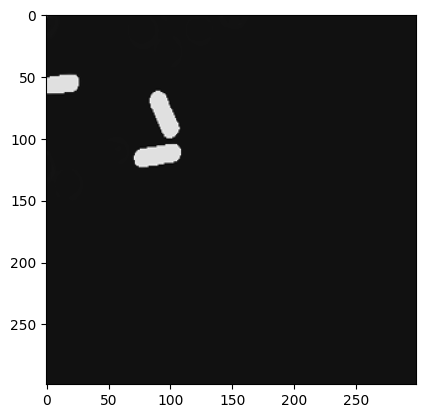

In [ ]:
i=25

plt.figure(1)
plt.imshow(input_evaluation[i,:,:,2], cmap='gray')
print("Real")
print(output_evaluation[i,:])
print("Prediction")
print(h[i])

In [ ]:
print("7 Layers  "+str(neuronas)+" Neuronas  "+str(dropout)+"Dropout")
print(mse)
print(r2)

7 Layers  1000 Neuronas  0.2Dropout
[[3.05313696]]
[[0.92142285]]


In [ ]:
model.save('7_1000_02_nanobars.keras')